In [13]:
%matplotlib inline

import os
# running with non gpu singularity container, so commented out the next line to use CPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
tf.set_random_seed(42)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
print "import tensorflow"
           
import keras.backend.tensorflow_backend as K

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU, Lambda
from keras.layers import Input, merge, Concatenate, concatenate
print "import keras"

import numpy as np
from tqdm import tqdm
import time
import pickle
import sys

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

print "import matplotlib"

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.stats import binned_statistic_2d

print "import sklearn"

np.random.seed(42)


import tensorflow
import keras
import matplotlib
import sklearn


In [181]:
def Minv(cols,ptetaphi=False,nopy2=False):
    """
    Computes M for two objects given the cartesian momentum projections
    if `ptetaphi` is True, then assumes the 8 input columns are cylindrical eptetaphi
    if `nopy2` is True, input is 7 columns with no py2
    """
    if ptetaphi:
        cols = ptetaphi_to_cartesian(cols)
    if nopy2:
        M2 = (cols[:,0]+cols[:,4])**2
        M2 -= (cols[:,1]+cols[:,5])**2
        M2 -= (cols[:,2]          )**2
        M2 -= (cols[:,3]+cols[:,6])**2
    else:
        M2 = (cols[:,0]+cols[:,4])**2
        M2 -= (cols[:,1]+cols[:,5])**2
        M2 -= (cols[:,2]+cols[:,6])**2
        M2 -= (cols[:,3]+cols[:,7])**2
    return np.sqrt(M2)

def cartesian_to_ptetaphi(eight_cartesian_cols):
    """
    Takes 8 columns as cartesian e px py pz e px py pz
    and converts to e pt eta phi e pt eta phi
    """
    e1 =  eight_cartesian_cols[:,0]
    e2 =  eight_cartesian_cols[:,4]
    px1 = eight_cartesian_cols[:,1]
    px2 = eight_cartesian_cols[:,5]
    py1 = eight_cartesian_cols[:,2]
    py2 = eight_cartesian_cols[:,6]
    pz1 = eight_cartesian_cols[:,3]
    pz2 = eight_cartesian_cols[:,7]
    p1 = np.sqrt(px1**2+py1**2+pz1**2)
    p2 = np.sqrt(px2**2+py2**2+pz2**2)
    pt1 = np.sqrt(px1**2+py1**2)
    pt2 = np.sqrt(px2**2+py2**2)
    phi1 = np.arctan2(py1,px1)
    phi2 = np.arctan2(py2,px2)
    eta1 = np.arctanh(pz1/p1)
    eta2 = np.arctanh(pz2/p2)
    return np.c_[e1,pt1,eta1,phi1,e2,pt2,eta2,phi2]

def ptetaphi_to_cartesian(eight_eptetaphi_cols):
    """
    Takes 8 columns as e pt eta phi e pt eta phi
    and converts to e px py pz e px py pz
    """
    e1 =  eight_eptetaphi_cols[:,0]
    e2 =  eight_eptetaphi_cols[:,4]
    pt1 =  eight_eptetaphi_cols[:,1]
    pt2 =  eight_eptetaphi_cols[:,5]
    eta1 =  eight_eptetaphi_cols[:,2]
    eta2 =  eight_eptetaphi_cols[:,6]
    phi1 =  eight_eptetaphi_cols[:,3]
    phi2 =  eight_eptetaphi_cols[:,7]
    px1 = np.abs(pt1)*np.cos(phi1)
    px2 = np.abs(pt2)*np.cos(phi2)
    py1 = np.abs(pt1)*np.sin(phi1)
    py2 = np.abs(pt2)*np.sin(phi2)
    pz1 = np.abs(pt1)/np.tan(2.0*np.arctan(np.exp(-1.*eta1)))
    pz2 = np.abs(pt2)/np.tan(2.0*np.arctan(np.exp(-1.*eta2)))
    return np.c_[e1,px1,py1,pz1,e2,px2,py2,pz2]

def cartesian_zerophi2(coords,ptetaphi=False):
    """
    returns 8-1=7 columns rotating leptons such that phi2 is 0 (and removing it)
    if `ptetaphi` is True, then return eptetaphi instead of epxpypz
    """
    lepcoords_cyl = cartesian_to_ptetaphi(lepcoords)
    phi1 = lepcoords_cyl[:,3]
    phi2 = lepcoords_cyl[:,7]
    dphi = phi1-phi2
    dphi[dphi>np.pi] -= 2*np.pi
    dphi[dphi<-np.pi] += 2*np.pi
    lepcoords_cyl[:,3] = dphi
    lepcoords_cyl[:,7] = 0.
    if ptetaphi:
        return np.delete(lepcoords_cyl, [7], axis=1)
    else:
        return np.delete(ptetaphi_to_cartesian(lepcoords_cyl), [6], axis=1)

In [182]:
def add_invmass_from_8cartesian(x):
    invmass = K.sqrt(
                (x[:,0:1]+x[:,4:5])**2-
                (x[:,1:2]+x[:,5:6])**2-
                (x[:,2:3]+x[:,6:7])**2-
                (x[:,3:4]+x[:,7:8])**2
                )
    return K.concatenate([x,invmass])

def fix_outputs(x):
    """
    Take nominal delphes format of 19 columns and fix some columns
    """
    return K.concatenate([
        # x[:,0:21],
        x[:,0:7], # epxpypz for lep1,lep2 -1 for no py2
        x[:,7:8], # nvtx
        K.sign(x[:,8:10]), # q1 q2
        x[:,10:12], # iso1 iso2
        x[:,12:14], # met, metphi
        x[:,14:19], # jet pts
#         x[:,0:8], # epxpypz for lep1,lep2
#         K.sign(x[:,8:9]), # lep1 charge
#         x[:,9:10], # lep1 iso
#         K.sign(x[:,10:11]), # lep2 charge
#         x[:,11:12], # lep2 iso
#         K.round(x[:,12:13]), # nvtxs
#         x[:,13:15], # met, metphi
#         K.round(x[:,15:16]), # ngenjets
#         x[:,16:21], # jet pts
        ])

In [183]:
class GAN():
    def __init__(self, **kwargs):

        self.args = dict(kwargs)

        self.tag = kwargs["tag"]
        self.input_file = str(kwargs["input_file"])
        self.noise_shape = (int(kwargs["noise_size"]),)
        self.output_shape = (int(kwargs["output_size"]),)
        self.noise_type = int(kwargs["noise_type"])
        self.ntest_samples = int(kwargs["ntest_samples"])
        self.nepochs_dump_pred_metrics = int(kwargs["nepochs_dump_pred_metrics"])
        self.nepochs_dump_models = int(kwargs["nepochs_dump_models"])
        self.nepochs_max = int(kwargs["nepochs_max"])
        self.batch_size = int(kwargs["batch_size"])
        self.do_concatenate_disc = kwargs["do_concatenate_disc"]
        self.do_concatenate_gen = kwargs["do_concatenate_gen"]
        self.do_batch_normalization_disc = kwargs["do_batch_normalization_disc"]
        self.do_batch_normalization_gen = kwargs["do_batch_normalization_gen"]
        self.do_soft_labels = kwargs["do_soft_labels"]
        self.do_noisy_labels = kwargs["do_noisy_labels"]
        self.do_tanh_gen = kwargs["do_tanh_gen"]
        self.nepochs_decay_noisy_labels = int(kwargs["nepochs_decay_noisy_labels"])
        self.use_ptetaphi_additionally = kwargs["use_ptetaphi_additionally"]
        self.optimizer_gen = kwargs["optimizer_gen"]
        self.optimizer_disc = kwargs["optimizer_disc"]
        self.depth_disc = kwargs["depth_disc"]
        self.width_disc = kwargs["width_disc"]
        self.depth_gen = kwargs["depth_gen"]
        self.width_gen = kwargs["width_gen"]
        self.beefy_generator = kwargs["beefy_generator"]
        self.add_invmass_disc = kwargs["add_invmass_disc"]
        self.fix_delphes_outputs = kwargs["fix_delphes_outputs"]
        self.use_delphes = kwargs["use_delphes"]
        if self.use_ptetaphi_additionally: self.output_shape = (self.output_shape[0]+8,)

        os.system("mkdir -p progress/{}/".format(self.tag))
        os.system("cp gan.py progress/{}/".format(self.tag))

        self.scaler_type = kwargs["scaler_type"]
        self.scaler = None
        if self.scaler_type.lower() == "minmax":
            self.scaler = MinMaxScaler(feature_range=(-1.,1.))
        elif self.scaler_type.lower() == "robust":
            self.scaler = RobustScaler()
        elif self.scaler_type.lower() == "standard":
            self.scaler = StandardScaler()

        self.data = None
        self.data_ref = None
        self.d_epochinfo = {}

        # optimizer = Adam(0.0002, 0.5)
        optimizer_d = self.optimizer_disc
        # optimizer_d = "sgd"
        optimizer_g = self.optimizer_gen
        # optimizer_g = "adam"

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer_d,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer_g)

        # The generator takes noise as input and generated imgs
        z = Input(shape=self.noise_shape)
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer_g)


In [184]:
class GAN(GAN):
    
    def build_generator(self):

        model = Sequential()

        ## Head
        model.add(Dense(64, input_shape=self.noise_shape))
        if self.do_batch_normalization_gen:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        if self.do_concatenate_gen:
            model.add(Lambda(lambda x: K.concatenate([x*x,x])))
            model.add(LeakyReLU(alpha=0.2))

        ## Main Body
        if self.depth_gen > 0 and self.width_gen > 0:
            for level in xrange(0,self.depth_gen):
                model.add(Dense(width_gen/(2**level))) #Triangle with width halved at each level
                model.add(LeakyReLU(alpha=0.2))
        elif self.beefy_generator:
            model.add(Dense(128))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(256))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(512))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(1024))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(1024))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(512))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(256))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(128))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(64))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(32))
            model.add(LeakyReLU(alpha=0.2))
        else:
            model.add(Dense(128))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(128))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(128))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(64))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(32))
            model.add(LeakyReLU(alpha=0.2))

        ## Tail
        model.add(Dense(self.output_shape[0]))
        if self.do_tanh_gen:
            model.add(Activation("tanh"))
        elif self.fix_delphes_outputs:
            model.add(Lambda(fix_outputs,
                input_shape=self.output_shape,
                output_shape=self.output_shape
                ))

        model.summary()

        noise = Input(shape=self.noise_shape)
        img = model(noise)

        return Model(noise, img)

In [185]:
class GAN(GAN):
    
    def build_discriminator(self):

        model = Sequential()

        ## Head
        if self.add_invmass_disc:
            model.add(Lambda(add_invmass_from_8cartesian,
                input_shape=self.output_shape,
                output_shape=(self.output_shape[0]+1,),
                ))
        else:
            model.add(Dense(128,input_shape=self.output_shape))

        if self.do_batch_normalization_disc:
            model.add(BatchNormalization())
        # model.add(LeakyReLU(alpha=0.2))
        if self.do_concatenate_disc:
            model.add(Lambda(lambda x: K.concatenate([x*x,x])))
            model.add(LeakyReLU(alpha=0.2))

        ## Main Body
        if self.depth_disc > 0 and self.width_disc > 0:
            for level in xrange(0,self.depth_disc):
                model.add(Dense(self.width_disc/(2**level))) #Triangle with width halved at each level
                model.add(LeakyReLU(alpha=0.2))
        else:
            model.add(Dense(128))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(128))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(128))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(128))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(128))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(64))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(32))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(16))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(8))
            model.add(LeakyReLU(alpha=0.2))

        ## Tail
        model.add(Dense(1,activation='sigmoid'))
        model.summary()

        img = Input(shape=self.output_shape)
        validity = model(img)

        return Model(img, validity)


In [186]:
class GAN(GAN):
    
    def load_data(self):
        if self.data is not None: return
        
        if self.use_delphes:
            self.data = np.load(self.input_file)
        else:
            self.data = np.load(self.input_file)

In [187]:
class GAN(GAN):
            
    def train(self):

        self.load_data()
        
        if self.use_delphes:
            lepcoords = np.c_[
                self.data["lep1_e"],
                self.data["lep1_px"],
                self.data["lep1_py"],
                self.data["lep1_pz"],
                self.data["lep2_e"],
                self.data["lep2_px"],
                self.data["lep2_py"],
                self.data["lep2_pz"],
            ]
            lepcoords_dphi = cartesian_zerophi2(lepcoords)
            
            nvtx_smeared = np.round(np.random.normal(self.data["nvtxs"],0.5))
            X_train = np.c_[
                lepcoords_dphi, # 7 columns
                nvtx_smeared, # 1 column
                self.data["lep1_charge"], self.data["lep2_charge"],
                self.data["lep1_iso"], self.data["lep2_iso"],
                self.data["met"], self.data["metphi"],
                self.data["genjet_pt1"],
                self.data["genjet_pt2"],
                self.data["genjet_pt3"],
                self.data["genjet_pt4"],
                self.data["genjet_pt5"],
            ].astype(np.float32)
        else:
            X_train = self.data[:,range(1,1+8)]
            if self.use_ptetaphi_additionally:
                X_train = np.c_[X_train, cartesian_to_ptetaphi(X_train)]

        # # NOTE. StandardScaler should be fit on training set
        # # and applied the same to train and test, otherwise we
        # # introduce a bias
        if self.scaler:
            self.scaler.fit(X_train)
            X_train = self.scaler.transform(X_train).astype(np.float32)
            pickle.dump(self.scaler, open("progress/{}/scaler.pkl".format(self.tag),'w'))

        half_batch = int(self.batch_size / 2)

        prev_gen_loss = -1
        prev_disc_loss = -1
        n_loss_same_gen = 0  # number of epochs for which generator loss has remained ~same (within 0.01%)
        n_loss_same_disc = 0  # number of epochs for which discriminator loss has remained ~same (within 0.01%)
        old_info = -1, -1
        for epoch in range(self.nepochs_max):

            if n_loss_same_gen > 500 or n_loss_same_disc > 500:
                print "BREAKING because disc/gen loss has remained the same for {}/{} epochs!".format(n_loss_same_disc,n_loss_same_gen)
                break

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            # nominal
            if self.noise_type == 1:
                noise_half = np.random.normal(0, 1, (half_batch, self.noise_shape[0]))
                noise_full = np.random.normal(0, 1, (self.batch_size, self.noise_shape[0]))

                if epoch % self.nepochs_dump_pred_metrics == 0 and epoch > 0:
                    noise_test = np.random.normal(0, 1, (self.ntest_samples,self.noise_shape[0]))

            elif self.noise_type == 2: # random soup, 4,2,2 have to be modified to sum to noise_shape[0]
                ngaus = self.noise_shape[0] // 2
                nflat = (self.noise_shape[0] - ngaus) // 2
                nexpo = self.noise_shape[0] - nflat - ngaus
                noise_gaus = np.random.normal( 0, 1, (half_batch+self.batch_size, ngaus))
                noise_flat = np.random.uniform(-1, 1, (half_batch+self.batch_size, nflat))
                noise_expo = np.random.exponential( 1,    (half_batch+self.batch_size, nexpo))
                noise = np.c_[ noise_gaus,noise_flat,noise_expo ]
                noise_half = noise[:half_batch]
                noise_full = noise[-self.batch_size:]

                if epoch % self.nepochs_dump_pred_metrics == 0 and epoch > 0:
                    noise_gaus = np.random.normal( 0, 1, (self.ntest_samples, ngaus))
                    noise_flat = np.random.uniform(-1, 1, (self.ntest_samples, nflat))
                    noise_expo = np.random.exponential( 1,    (self.ntest_samples, nexpo))
                    noise_test = np.c_[ noise_gaus,noise_flat,noise_expo ]

            # truth conditioned
            elif self.noise_type == 3:
                noise_half = np.c_[
                        X_train[np.random.randint(0, X_train.shape[0], half_batch)],
                        np.random.normal(0, 1, (half_batch,self.noise_shape[0]-X_train.shape[1]))
                        ]
                noise_full = np.c_[
                        X_train[np.random.randint(0, X_train.shape[0], self.batch_size)],
                        np.random.normal(0, 1, (self.batch_size,self.noise_shape[0]-X_train.shape[1]))
                        ]

                if epoch % self.nepochs_dump_pred_metrics == 0 and epoch > 0:
                    noise_test = np.c_[
                            X_train[np.random.randint(0, X_train.shape[0], self.ntest_samples)],
                            np.random.normal(0, 1, (self.ntest_samples,self.noise_shape[0]-X_train.shape[1]))
                            ]

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise_half)

            # Train the discriminator
            ones = np.ones((half_batch, 1))
            zeros = np.zeros((half_batch, 1))

            if self.do_soft_labels:
                ones *= 0.9

            if self.do_noisy_labels:
                frac = 0.3*np.exp(-epoch/self.nepochs_decay_noisy_labels)
                if frac > 0.005:
                    ones[np.random.randint(0, len(ones), int(frac*len(ones)))] = 0
                    zeros[np.random.randint(0, len(zeros), int(frac*len(zeros)))] = 1

            d_loss_real = self.discriminator.train_on_batch(imgs, ones)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, zeros)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------
            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * self.batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise_full, valid_y)

            if (g_loss - prev_gen_loss) < 0.0001: n_loss_same_gen += 1
            else: n_loss_same_gen = 0
            prev_gen_loss = g_loss

            if (d_loss[0] - prev_disc_loss) < 0.0001: n_loss_same_disc += 1
            else: n_loss_same_disc = 0
            prev_disc_loss = d_loss[0]

            # Plot the progress
#             print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            sys.stdout.write("\r{} [D loss: {}, acc.: {:.2f}%] [G loss: {}] [mll={:.3f}+-{:.3f}]".format(epoch, d_loss[0], 100*d_loss[1], g_loss, old_info[0], old_info[1]))

            if epoch % self.nepochs_dump_pred_metrics == 0 and epoch > 0:
            
                sys.stdout.write("\n") # break up the stream of text

                gen_imgs = self.generator.predict(noise_test)

                if self.scaler:
                    gen_imgs = self.scaler.inverse_transform(gen_imgs)

                masses = Minv(gen_imgs)
                masses = masses[np.isfinite(masses)]
                old_info = masses.mean(), masses.std()

                if "epoch" not in self.d_epochinfo:
                    self.d_epochinfo["epoch"] = []
                    self.d_epochinfo["d_acc"] = []
                    self.d_epochinfo["d_loss"] = []
                    self.d_epochinfo["g_loss"] = []
                    self.d_epochinfo["mass_mu"] = []
                    self.d_epochinfo["mass_sig"] = []
                    self.d_epochinfo["time"] = []
                    self.d_epochinfo["args"] = self.args
                else:
                    self.d_epochinfo["epoch"].append(epoch)
                    self.d_epochinfo["d_acc"].append(100*d_loss[1])
                    self.d_epochinfo["d_loss"].append(d_loss[0])
                    self.d_epochinfo["g_loss"].append(g_loss)
                    self.d_epochinfo["mass_mu"].append(masses.mean())
                    self.d_epochinfo["mass_sig"].append(masses.std())
                    self.d_epochinfo["time"].append(time.time())

                pickle.dump(self.d_epochinfo, open("progress/{}/history.pkl".format(self.tag),'w'))

            if epoch % self.nepochs_dump_models == 0 and epoch > 0:
                self.discriminator.save("progress/{}/disc_{}.weights".format(self.tag,epoch))
                self.generator.save("progress/{}/gen_{}.weights".format(self.tag,epoch))

In [189]:
# defaults
params = {
        "input_file": "data_xyz.npy",
        "output_size": 8,
        "noise_size": 8,
        "noise_type": 1,
        "ntest_samples": 5000,
        "nepochs_dump_pred_metrics": 250,
        "nepochs_dump_models": 5000,
        "nepochs_max": 30001,
        "batch_size": 200,
        "do_concatenate_disc": False,
        "do_concatenate_gen": False,
        "do_batch_normalization_disc": False,
        "do_batch_normalization_gen": False,
        "do_soft_labels": False,
        "do_noisy_labels": False,
        "do_tanh_gen": False,
        "nepochs_decay_noisy_labels": 3000,
        "use_ptetaphi_additionally": False,
        "scaler_type": "",
        "optimizer_disc": "adadelta",
        "optimizer_gen": "adadelta",
        "beefy_generator": False,
        "depth_gen": 0,
        "width_gen": 0,
        "depth_disc": 0,
        "width_disc": 0,
        "add_invmass_disc": False,
        "fix_delphes_outputs": False,
        "use_delphes": False,
        }

# for delphes:
params.update({
    "use_delphes": True,
    "fix_delphes_outputs": True,
    "do_soft_labels": True,
    "do_noisy_labels": True,
    "nepochs_decay_noisy_labels": 2000,
    "input_file": "/home/users/namin/2017/gan/DY-GAN/delphes/data_Nov10.npa",
    "output_size": 19,
})
print params
    
# change tag for provenance
params["tag"] = "vtest"

gan = GAN(**params)

{'width_disc': 0, 'ntest_samples': 5000, 'output_size': 19, 'do_batch_normalization_disc': False, 'use_delphes': True, 'use_ptetaphi_additionally': False, 'optimizer_disc': 'adadelta', 'fix_delphes_outputs': True, 'nepochs_dump_pred_metrics': 250, 'do_batch_normalization_gen': False, 'add_invmass_disc': False, 'width_gen': 0, 'noise_type': 1, 'nepochs_dump_models': 5000, 'input_file': '/home/users/namin/2017/gan/DY-GAN/delphes/data_Nov10.npa', 'scaler_type': '', 'batch_size': 200, 'do_concatenate_disc': False, 'do_soft_labels': True, 'depth_gen': 0, 'noise_size': 8, 'do_noisy_labels': True, 'nepochs_max': 30001, 'depth_disc': 0, 'do_tanh_gen': False, 'do_concatenate_gen': False, 'beefy_generator': False, 'nepochs_decay_noisy_labels': 2000, 'optimizer_gen': 'adadelta'}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_235 (Dense)            (None, 128)               2560      
_______________________

In [ ]:
gan.train()

250 [D loss: 0.459872126579, acc.: 44.50%] [G loss: 2.82814383507] [mll=-1.000+--1.000]]
500 [D loss: 0.416689604521, acc.: 45.00%] [G loss: 2.34388518333] [mll=52.769+-8.571]]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:163: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:179: RuntimeWarning: Mean of empty slice.


750 [D loss: 0.435890734196, acc.: 44.50%] [G loss: 2.132147789] [mll=nan+-nan]n]]
1000 [D loss: 0.42704257369, acc.: 44.50%] [G loss: 2.21776294708] [mll=51.629+-6.831]
1250 [D loss: 0.421676516533, acc.: 44.50%] [G loss: 2.30919766426] [mll=18.056+-1.792]
1500 [D loss: 0.420112669468, acc.: 44.50%] [G loss: 2.21528601646] [mll=61.426+-7.152]]
1750 [D loss: 0.415970265865, acc.: 44.50%] [G loss: 2.24930381775] [mll=43.094+-4.217]
2000 [D loss: 0.472355365753, acc.: 44.50%] [G loss: 2.24461960793] [mll=14.042+-0.746]
2250 [D loss: 0.294913113117, acc.: 48.00%] [G loss: 3.34412455559] [mll=107.564+-8.315]
2500 [D loss: 0.286200761795, acc.: 48.00%] [G loss: 3.25450134277] [mll=180.351+-23.186]
2750 [D loss: 0.285238087177, acc.: 48.00%] [G loss: 3.55289006233] [mll=17.265+-1.079]
3000 [D loss: 0.285041481256, acc.: 48.00%] [G loss: 3.20800995827] [mll=nan+-nan]
3250 [D loss: 0.284811139107, acc.: 48.00%] [G loss: 3.22374820709] [mll=nan+-nan]
3500 [D loss: 0.283866852522, acc.: 48.00%] 

In [160]:
data = np.load("/home/users/namin/2017/gan/DY-GAN/delphes/data_Nov10.npa")

('mll', 'lep1_e', 'lep1_px', 'lep1_py', 'lep1_pz', 'lep2_e', 'lep2_px', 'lep2_py', 'lep2_pz', 'lep1_charge', 'lep1_iso', 'lep2_charge', 'lep2_iso', 'nvtxs', 'met', 'metphi', 'ngenjets', 'genjet_pt1', 'genjet_pt2', 'genjet_pt3', 'genjet_pt4', 'genjet_pt5')


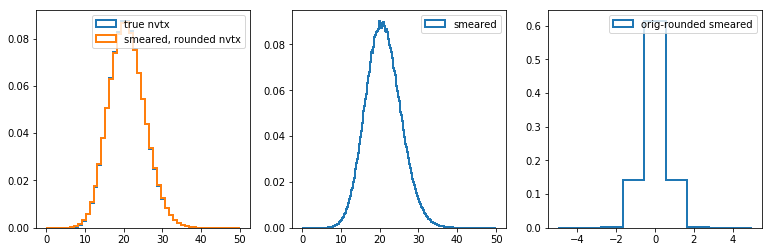

In [161]:
# gan.load_data()
print data.dtype.names
nvtx = data["nvtxs"]
# for each nvtx, draw a gaussian distributed number with mu,sig = (nvtx,0.5)
# these will be the continuous numbers we use with the generator
# then round it (these will be the values at the end of the day)
# so these rounded gaus numbers should ~match original nvtx distribution
nvtx_smeared_unrounded = np.random.normal(nvtx,0.5)
nvtx_smeared = np.round(nvtx_smeared_unrounded)

fix,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(13,4))
_ = ax1.hist(nvtx,bins=np.linspace(0,50,50), histtype="step",lw=2,density=True,label="true nvtx")
_ = ax1.hist(nvtx_smeared,bins=np.linspace(0,50,50), histtype="step",lw=2,density=True,label="smeared, rounded nvtx")
_ = ax2.hist(nvtx_smeared_unrounded,bins=np.linspace(0,50,500), histtype="step",lw=2,density=True,label="smeared")
_ = ax3.hist(nvtx-nvtx_smeared,bins=np.linspace(-5,5,10), histtype="step",lw=2,density=True,label="orig-rounded smeared")
_ = ax1.legend()
_ = ax2.legend()
_ = ax3.legend()